In [1]:
# Provides a way of using operating system dependent functionality. 
import os

# LibROSA provides the audio analysis
import librosa
# Need to implictly import from librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

# Enable plot in the notebook
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd


# To build Neural Network and Create desired Model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input, 
from keras.layers import Dense #, Embedding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


#  Data Preparation


### Plotting the audio file's waveform and its spectrogram

In [2]:
data, sampling_rate = librosa.load('Dataset/anger/anger016.wav')
# To play audio this in the jupyter notebook
ipd.Audio('Dataset/anger/anger016.wav')

In [3]:
len(data)

87553

In [4]:
sampling_rate

22050

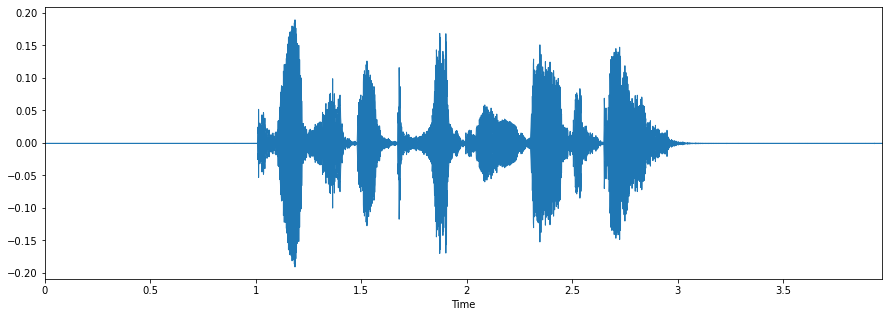

In [5]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

### Setup the Basic Paramter

### Converting Dataset in CSV format

it will cause easy operation on Dataset.

In [6]:
dataset_path = os.path.abspath('./Dataset')
destination_path = os.path.abspath('./')
# To shuffle the dataset instances/records
randomize = True
# for spliting dataset into training and testing dataset
split = 0.8
# Number of sample per second e.g. 16KHz
sampling_rate = 20000 
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]

In [8]:
import sys
!{sys.executable} -m pip install torchvision

distutils: C:\Users\Deejaey\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\Deejaey\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\Deejaey\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\Deejaey\anaconda3\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'C:\Users\Deejaey\anaconda3\python.exe -m pip install --upgrade pip' command.


In [9]:
# import required libraries
import os
import sys
import csv
import librosa
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
np.random.seed(42)

def create_meta_csv(dataset_path, destination_path):
    """Create a meta csv file given a dataset folder path of Audio.
    
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The file will contain audios and their labels. This file can be then used to make
    train, test and val splits, randomize them and load few of them (a mini-batch) in memory
    as required. The file is saved in dataset_path folder if destination_path is not provided.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta file /path to dataset
    Returns:
        True (bool): Returns True if 'dataset_attr.csv' was created successfully else returns an exception
    """
    # Change dataset path accordingly
    DATASET_PATH = os.path.abspath(dataset_path)
    csv_path=os.path.join(destination_path, 'dataset_attr.csv')
    flist = []
    emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
    for root, dirs, files in os.walk(DATASET_PATH, topdown=False):
        for name in files:
            if (name.endswith('.wav')): 
                fullName = os.path.join(root, name)
                flist.append(fullName)

    split_format = str('/') if sys.platform=='linux' else str('\\')
    
    filenames=[]
    for idx,file in enumerate(flist):
        filenames.append(file.split(split_format)) 
        # print(filenames[idx])
    types=[]
    for idx,path in enumerate(filenames):
        types.append((flist[idx],emotions.index(path[-2]))) 

    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([("path","label")])
        writer.writerows(types)
    f.close()
    # change destination_path to DATASET_PATH if destination_path is None 
    if destination_path == None:
        destination_path = DATASET_PATH
        # write out as dataset_attr.csv in destination_path directory
        # if no error
    return True

def create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=None):
    """Create a meta csv file given a dataset folder path of audios and loads it as a pandas dataframe.
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The function will return pandas dataframes for the csv and also train and test splits if you specify a 
    fraction in split parameter.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta csv file
        randomize (bool, optional): Randomize the csv records. Defaults to True
        split (double, optional): Percentage of train records. Defaults to None
    Returns:
        dframe (pandas.Dataframe): Returns a single Dataframe for csv if split is none, else returns more two Dataframes for train and test splits.
        train_set (pandas.Dataframe): Returns a Dataframe of length (split) * len(dframe)
        test_set (pandas.Dataframe): Returns a Dataframe of length (1 - split) * len(dframe)
    """
    if create_meta_csv(dataset_path, destination_path=destination_path):
        dframe = pd.read_csv(os.path.join(destination_path, 'dataset_attr.csv'))

    # shuffle if randomize is True or if split specified and randomize is not specified 
    # so default behavior is split
    if randomize == True or (split != None and randomize == None):
        # shuffle the dataframe here
        dframe=dframe.sample(frac=1).reset_index(drop=True)
        pass

    if split != None:
        train_set, test_set = train_test_split(dframe, split)
        return dframe, train_set, test_set 
    
    return dframe

In [10]:
def train_test_split(dframe, split_ratio):
    """Splits the dataframe into train and test subset dataframes.
    Args:
        split_ration (float): Divides dframe into two splits.
    Returns:
        train_data (pandas.Dataframe): Returns a Dataframe of length (split_ratio) * len(dframe)
        test_data (pandas.Dataframe): Returns a Dataframe of length (1 - split_ratio) * len(dframe)
    """
    # divide into train and test dataframes
    train_data= dframe.iloc[:int((split_ratio) * len(dframe)), :]
    test_data= dframe.iloc[int((split_ratio) * len(dframe)):,:]
    test_data=test_data.reset_index(drop=True) #reset index for test data
    return train_data, test_data

In [11]:
# loading dataframes using dataset module 


# To know more about "create_and_load_meta_csv_df" function and it's working, go to "./utils/dataset.py" script. 
df, train_df, test_df = create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [12]:
print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\ntesting Samples  : ", len(test_df))

Dataset samples  :  2556 
Training Samples :  2044 
testing Samples  :  512


# 4. Data Visualization

Let's understand what is our dataset.

In [13]:
df.head()

,path,label
0,C:\Users\Deejaey\Emotion Speech Recognition\Da...,3
1,C:\Users\Deejaey\Emotion Speech Recognition\Da...,4
2,C:\Users\Deejaey\Emotion Speech Recognition\Da...,5
3,C:\Users\Deejaey\Emotion Speech Recognition\Da...,0
4,C:\Users\Deejaey\Emotion Speech Recognition\Da...,3


In [14]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])


Actual Audio :  C:\Users\Deejaey\Emotion Speech Recognition\Dataset\happy\happy143.wav
Labels       :  3



### Labels Assigned for emotions : 
- 0 : anger
- 1 : disgust
- 2 : fear
- 3 : happy
- 4 : neutral 
- 5 : sad
- 6 : surprise


In [15]:
unique_labels = train_df.label.unique()
unique_labels.sort()
print("unique labels in Emtion dataset : ")
print(*unique_labels, sep=', ')
unique_labels_counts = train_df.label.value_counts(sort=False)
print("\n\nCount of unique labels in Emtion dataset : ")
print(*unique_labels_counts,sep=', ')

unique labels in Emtion dataset : 
0, 1, 2, 3, 4, 5, 6


Count of unique labels in Emtion dataset : 
363, 201, 346, 346, 240, 353, 195


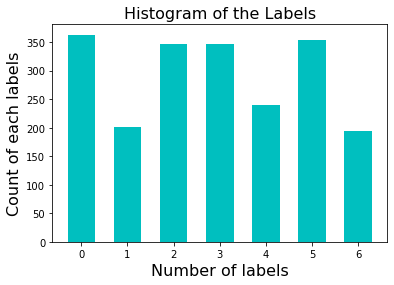

In [16]:
# Histogram
plt.bar(unique_labels, unique_labels_counts,align = 'center', width=0.6, color = 'c')
plt.xlabel('Number of labels', fontsize=16)
plt.xticks(unique_labels)
plt.ylabel('Count of each labels', fontsize=16)
plt.title('Histogram of the Labels', fontsize=16)
plt.show()

In [17]:
from tensorflow.keras import optimizers

# 5. Data Pre-Processing

### Getting the features of audio files using librosa

Calculating MFCC, Pitch, magnitude, Chroma features.

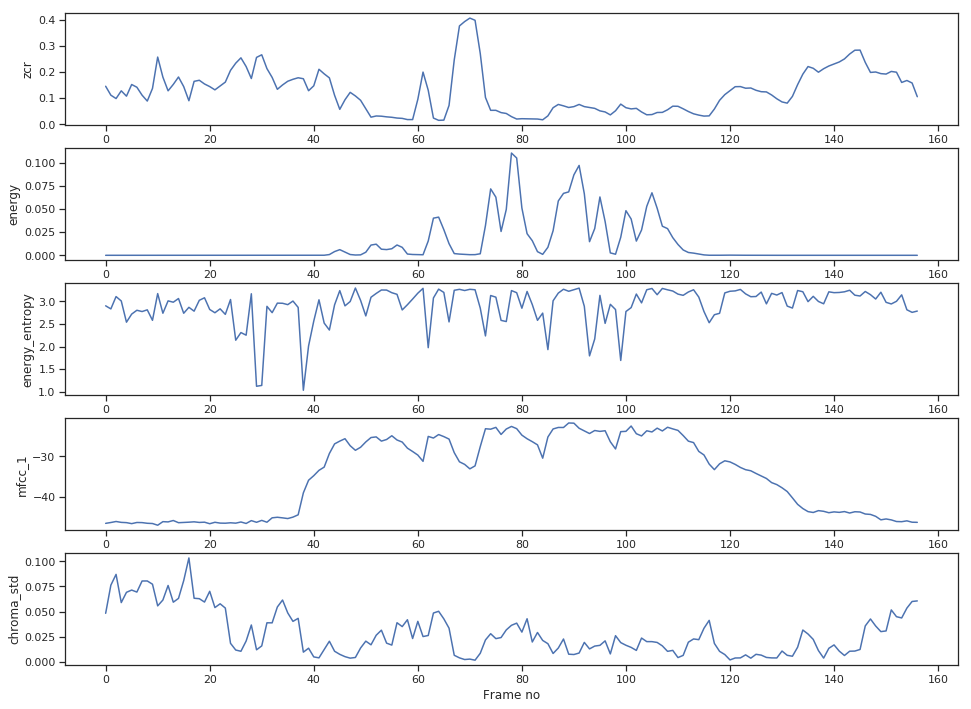

In [18]:
display(Image.open('./utils/images/feature_plots.png'))

In [19]:
from utils.feature_extraction import get_features_dataframe
from utils.feature_extraction import get_audio_features

In [20]:

# trainfeatures, trainlabel = get_features_dataframe(train_df, sampling_rate)
# testfeatures, testlabel = get_features_dataframe(test_df, sampling_rate)

# I have ran above 2 lines and get the featured dataframe. 
# and store it into pickle file to use it for later purpose.
# it take too much time to generate features(around 30-40 minutes).

trainfeatures = pd.read_pickle('./features_dataframe/trainfeatures')
trainlabel = pd.read_pickle('./features_dataframe/trainlabel')
testfeatures = pd.read_pickle('./features_dataframe/testfeatures')
testlabel = pd.read_pickle('./features_dataframe/testlabel')

In [21]:
trainfeatures.shape

(2044, 65)

In [22]:
trainfeatures = trainfeatures.fillna(0)
testfeatures = testfeatures.fillna(0)

In [23]:
# By using .ravel() : Converting 2D to 1D to prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()


In [63]:
X_train

array([[-4.61981438e+02,  8.80196465e+01, -4.18530762e+01, ...,
         3.43809640e-01,  2.61945186e-01,  2.40617305e-01],
       [-6.64422738e+02,  8.10042462e+01,  5.14174752e+00, ...,
         4.70700179e-01,  5.36138052e-01,  5.01616175e-01],
       [-3.89478610e+02,  5.30126908e+01, -2.70896634e+01, ...,
         2.90602413e-01,  2.41563554e-01,  2.11638810e-01],
       ...,
       [-3.92628377e+02,  7.26534041e+01, -3.75287316e+01, ...,
         4.57313244e-01,  3.84327917e-01,  3.57880285e-01],
       [-2.97907288e+02,  1.59552220e+02,  1.64509203e+01, ...,
         4.58397761e-01,  4.41783051e-01,  4.84818733e-01],
       [-2.14078355e+02,  1.36917442e+02, -2.00511584e+01, ...,
         4.87592898e-01,  4.15729549e-01,  4.09361434e-01]])

In [24]:
y_train[:5]

array([3, 2, 2, 0, 3], dtype=int64)

In [25]:
# One-Hot Encoding
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [26]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

### Changing dimension for CNN model

In [27]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [28]:
x_traincnn.shape

(2044, 65, 1)

# 6. Model Creation

In [29]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 65, 256)           1536      
_________________________________________________________________
activation (Activation)      (None, 65, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 65, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 65, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 65, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            8

In [31]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

# 7. Training and Evaluation

In [32]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=370, validation_data=(x_testcnn, y_test))

Epoch 1/370
128/128 [==============================] - 11s 57ms/step - loss: 2.4015 - accuracy: 0.1696 - val_loss: 1.8443 - val_accuracy: 0.2363
Epoch 2/370
128/128 [==============================] - 5s 41ms/step - loss: 1.9329 - accuracy: 0.2135 - val_loss: 1.7537 - val_accuracy: 0.2832
Epoch 3/370
128/128 [==============================] - 5s 41ms/step - loss: 1.8188 - accuracy: 0.2661 - val_loss: 1.7240 - val_accuracy: 0.2812
Epoch 4/370
128/128 [==============================] - 5s 41ms/step - loss: 1.7745 - accuracy: 0.2924 - val_loss: 1.6784 - val_accuracy: 0.3379
Epoch 5/370
128/128 [==============================] - 5s 42ms/step - loss: 1.7724 - accuracy: 0.3104 - val_loss: 1.6465 - val_accuracy: 0.3438
Epoch 6/370
128/128 [==============================] - 6s 48ms/step - loss: 1.7020 - accuracy: 0.3304 - val_loss: 1.6322 - val_accuracy: 0.3594
Epoch 7/370
128/128 [==============================] - 5s 42ms/step - loss: 1.6418 - accuracy: 0.3616 - val_loss: 1.5885 - val_accuracy

128/128 [==============================] - 6s 47ms/step - loss: 1.1470 - accuracy: 0.5901 - val_loss: 1.3054 - val_accuracy: 0.4902
Epoch 58/370
128/128 [==============================] - 6s 47ms/step - loss: 1.1741 - accuracy: 0.5669 - val_loss: 1.3035 - val_accuracy: 0.5020
Epoch 59/370
128/128 [==============================] - 6s 47ms/step - loss: 1.1709 - accuracy: 0.5570 - val_loss: 1.2897 - val_accuracy: 0.4902
Epoch 60/370
128/128 [==============================] - 6s 46ms/step - loss: 1.1686 - accuracy: 0.5488 - val_loss: 1.2844 - val_accuracy: 0.5078
Epoch 61/370
128/128 [==============================] - 6s 46ms/step - loss: 1.1599 - accuracy: 0.5614 - val_loss: 1.2757 - val_accuracy: 0.4980
Epoch 62/370
128/128 [==============================] - 6s 47ms/step - loss: 1.1100 - accuracy: 0.6065 - val_loss: 1.2790 - val_accuracy: 0.5137
Epoch 63/370
128/128 [==============================] - 6s 49ms/step - loss: 1.1431 - accuracy: 0.5765 - val_loss: 1.3370 - val_accuracy: 0.455

128/128 [==============================] - 6s 47ms/step - loss: 0.9211 - accuracy: 0.6722 - val_loss: 1.2168 - val_accuracy: 0.5273
Epoch 114/370
128/128 [==============================] - 6s 46ms/step - loss: 0.9214 - accuracy: 0.6879 - val_loss: 1.2312 - val_accuracy: 0.5215
Epoch 115/370
128/128 [==============================] - 6s 48ms/step - loss: 0.9811 - accuracy: 0.6359 - val_loss: 1.1781 - val_accuracy: 0.5234
Epoch 116/370
128/128 [==============================] - 6s 48ms/step - loss: 0.9455 - accuracy: 0.6600 - val_loss: 1.1879 - val_accuracy: 0.5371
Epoch 117/370
128/128 [==============================] - 6s 45ms/step - loss: 0.9369 - accuracy: 0.6825 - val_loss: 1.1985 - val_accuracy: 0.5254
Epoch 118/370
128/128 [==============================] - 6s 46ms/step - loss: 0.9624 - accuracy: 0.6559 - val_loss: 1.1890 - val_accuracy: 0.5312
Epoch 119/370
128/128 [==============================] - 6s 47ms/step - loss: 0.9260 - accuracy: 0.6759 - val_loss: 1.1861 - val_accuracy:

128/128 [==============================] - 6s 46ms/step - loss: 0.8028 - accuracy: 0.7154 - val_loss: 1.1321 - val_accuracy: 0.5527
Epoch 170/370
128/128 [==============================] - 6s 49ms/step - loss: 0.7932 - accuracy: 0.7227 - val_loss: 1.1330 - val_accuracy: 0.5625
Epoch 171/370
128/128 [==============================] - 7s 52ms/step - loss: 0.7848 - accuracy: 0.7239 - val_loss: 1.1245 - val_accuracy: 0.5566
Epoch 172/370
128/128 [==============================] - 6s 47ms/step - loss: 0.7963 - accuracy: 0.7245 - val_loss: 1.1407 - val_accuracy: 0.5410
Epoch 173/370
128/128 [==============================] - 6s 47ms/step - loss: 0.8028 - accuracy: 0.7102 - val_loss: 1.1374 - val_accuracy: 0.5605
Epoch 174/370
128/128 [==============================] - 6s 47ms/step - loss: 0.7843 - accuracy: 0.7300 - val_loss: 1.1178 - val_accuracy: 0.5742
Epoch 175/370
128/128 [==============================] - 6s 50ms/step - loss: 0.8226 - accuracy: 0.6973 - val_loss: 1.1155 - val_accuracy:

128/128 [==============================] - 6s 47ms/step - loss: 0.7058 - accuracy: 0.7544 - val_loss: 1.0838 - val_accuracy: 0.5723
Epoch 226/370
128/128 [==============================] - 6s 46ms/step - loss: 0.7216 - accuracy: 0.7571 - val_loss: 1.1237 - val_accuracy: 0.5703
Epoch 227/370
128/128 [==============================] - 6s 50ms/step - loss: 0.6845 - accuracy: 0.7571 - val_loss: 1.1263 - val_accuracy: 0.5684
Epoch 228/370
128/128 [==============================] - 6s 47ms/step - loss: 0.6723 - accuracy: 0.7796 - val_loss: 1.1377 - val_accuracy: 0.5781
Epoch 229/370
128/128 [==============================] - 6s 49ms/step - loss: 0.6774 - accuracy: 0.7619 - val_loss: 1.1011 - val_accuracy: 0.5723
Epoch 230/370
128/128 [==============================] - 7s 52ms/step - loss: 0.6872 - accuracy: 0.7608 - val_loss: 1.0993 - val_accuracy: 0.5664
Epoch 231/370
128/128 [==============================] - 6s 47ms/step - loss: 0.6814 - accuracy: 0.7438 - val_loss: 1.0963 - val_accuracy:

128/128 [==============================] - 6s 46ms/step - loss: 0.6097 - accuracy: 0.7840 - val_loss: 1.0805 - val_accuracy: 0.5840
Epoch 282/370
128/128 [==============================] - 6s 49ms/step - loss: 0.5866 - accuracy: 0.7909 - val_loss: 1.1029 - val_accuracy: 0.5742
Epoch 283/370
128/128 [==============================] - 6s 46ms/step - loss: 0.5854 - accuracy: 0.7925 - val_loss: 1.0733 - val_accuracy: 0.5938
Epoch 284/370
128/128 [==============================] - 6s 46ms/step - loss: 0.6072 - accuracy: 0.7899 - val_loss: 1.0946 - val_accuracy: 0.6055
Epoch 285/370
128/128 [==============================] - 6s 46ms/step - loss: 0.6143 - accuracy: 0.7891 - val_loss: 1.0775 - val_accuracy: 0.5898
Epoch 286/370
128/128 [==============================] - 6s 46ms/step - loss: 0.6399 - accuracy: 0.7924 - val_loss: 1.0671 - val_accuracy: 0.5898
Epoch 287/370
128/128 [==============================] - 6s 46ms/step - loss: 0.5694 - accuracy: 0.8067 - val_loss: 1.0972 - val_accuracy:

128/128 [==============================] - 6s 49ms/step - loss: 0.5245 - accuracy: 0.8330 - val_loss: 1.1719 - val_accuracy: 0.5547
Epoch 338/370
128/128 [==============================] - 6s 50ms/step - loss: 0.5774 - accuracy: 0.7946 - val_loss: 1.1279 - val_accuracy: 0.5840
Epoch 339/370
128/128 [==============================] - 6s 47ms/step - loss: 0.5476 - accuracy: 0.8137 - val_loss: 1.1002 - val_accuracy: 0.5762
Epoch 340/370
128/128 [==============================] - 6s 50ms/step - loss: 0.5273 - accuracy: 0.8219 - val_loss: 1.0731 - val_accuracy: 0.6074
Epoch 341/370
128/128 [==============================] - 6s 50ms/step - loss: 0.5098 - accuracy: 0.8296 - val_loss: 1.1205 - val_accuracy: 0.5547
Epoch 342/370
128/128 [==============================] - 6s 51ms/step - loss: 0.5116 - accuracy: 0.8317 - val_loss: 1.1129 - val_accuracy: 0.5820
Epoch 343/370
128/128 [==============================] - 6s 48ms/step - loss: 0.5027 - accuracy: 0.8241 - val_loss: 1.0544 - val_accuracy:

### Loss Vs Iterations

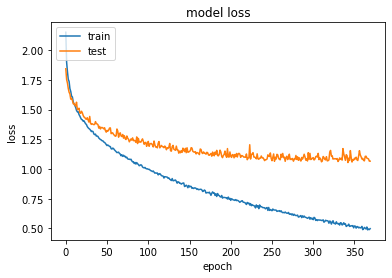

In [33]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

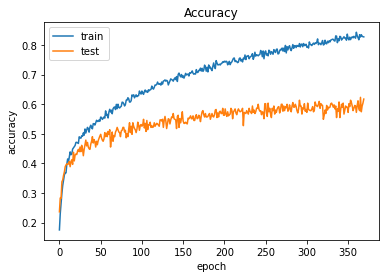

In [34]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving the model

In [35]:
model_name = 'omar.h5'
save_dir = os.path.join(os.getcwd(), 'Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Deejaey\Emotion Speech Recognition\Trained_Models\omar.h5 


In [36]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Loading the model

In [37]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./Trained_Models/omar.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))



Loaded model from disk
accuracy: 61.72%


# 8. Test Set Prediction

### Predicting emotions on the test data

In [38]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

16/16 [==============================] - 1s 24ms/step


In [39]:
preds

array([[1.9393042e-02, 1.8768718e-02, 8.9444959e-01, ..., 9.2884423e-03,
        3.1083142e-03, 5.3961828e-02],
       [8.4975880e-01, 6.9020456e-04, 7.4137710e-02, ..., 3.3870085e-05,
        6.4581190e-04, 8.7869834e-05],
       [1.6720727e-02, 8.7184316e-01, 5.8219982e-03, ..., 7.9388916e-02,
        5.2099712e-03, 1.6977875e-02],
       ...,
       [5.3897095e-03, 8.1958866e-01, 1.2899414e-01, ..., 1.0501725e-02,
        4.8190160e-03, 4.6566511e-03],
       [9.5805740e-03, 2.6322594e-05, 1.7105159e-01, ..., 1.2205100e-05,
        2.8527778e-01, 4.5794557e-05],
       [6.5902583e-02, 7.0721053e-02, 1.5637520e-01, ..., 2.6783964e-03,
        3.1853053e-03, 6.6536987e-01]], dtype=float32)

In [40]:
preds1=preds.argmax(axis=1)

In [41]:
preds1

array([2, 0, 1, 3, 3, 0, 3, 5, 3, 2, 2, 2, 0, 4, 4, 3, 2, 5, 1, 5, 2, 1,
       3, 4, 0, 0, 0, 2, 2, 3, 3, 4, 5, 3, 0, 3, 2, 3, 2, 3, 4, 6, 1, 0,
       5, 1, 1, 0, 1, 5, 1, 3, 2, 2, 5, 5, 2, 0, 5, 4, 4, 0, 2, 1, 0, 3,
       6, 2, 0, 0, 3, 2, 6, 2, 4, 5, 5, 6, 0, 1, 5, 1, 0, 2, 3, 3, 6, 0,
       2, 2, 3, 0, 4, 2, 2, 3, 6, 5, 4, 2, 2, 4, 5, 5, 3, 1, 2, 3, 6, 3,
       2, 0, 0, 3, 4, 2, 5, 2, 2, 1, 2, 3, 6, 0, 0, 5, 6, 2, 2, 1, 1, 0,
       1, 3, 4, 0, 3, 0, 1, 6, 0, 0, 1, 2, 0, 0, 1, 3, 4, 2, 5, 0, 4, 0,
       5, 5, 1, 0, 3, 1, 0, 5, 5, 5, 0, 1, 4, 4, 3, 6, 6, 3, 1, 4, 1, 1,
       2, 1, 2, 5, 1, 0, 4, 6, 0, 2, 2, 2, 1, 0, 2, 0, 4, 1, 4, 1, 0, 6,
       2, 0, 0, 2, 3, 4, 6, 3, 4, 6, 0, 4, 3, 3, 2, 2, 1, 6, 3, 6, 5, 4,
       5, 0, 0, 2, 4, 4, 1, 5, 3, 1, 5, 1, 4, 4, 0, 3, 4, 5, 1, 6, 6, 4,
       5, 2, 4, 5, 5, 2, 1, 0, 1, 4, 0, 5, 0, 1, 1, 5, 3, 1, 3, 3, 4, 4,
       2, 6, 5, 1, 2, 2, 5, 4, 2, 1, 1, 3, 3, 5, 0, 0, 2, 2, 5, 3, 1, 5,
       3, 6, 5, 1, 5, 3, 4, 6, 5, 0, 2, 5, 1, 0, 5,

In [42]:
abc = preds1.astype(int).flatten()

In [43]:
predictions = (lb.inverse_transform((abc)))

In [44]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,2
1,0
2,1
3,3
4,3
5,0
6,3
7,5
8,3
9,2


In [45]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [46]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,2
1,0
2,1
3,2
4,3
5,6
6,6
7,5
8,3
9,5


In [47]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [48]:
finaldf[130:140]

,actualvalues,predictedvalues
130,1,1
131,5,0
132,1,1
133,3,3
134,4,4
135,0,0
136,3,3
137,0,0
138,1,1
139,6,6


In [49]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
0,81
1,60
2,83
3,85
4,53
5,97
6,53


In [50]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
0,87
1,74
2,98
3,81
4,49
5,77
6,46


In [51]:
finaldf.to_csv('Predictions.csv', index=False)

# 9. Live Demonstration

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [52]:
demo_audio_path = './Dataset/happy/happy003.wav'
ipd.Audio('./Dataset/happy/happy003.wav')

In [53]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path,sampling_rate)

mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)
demo_audio_features = pd.concat([mfcc,pit,mag,C],ignore_index=True)

In [54]:
demo_audio_features= np.expand_dims(demo_audio_features, axis=0)
demo_audio_features= np.expand_dims(demo_audio_features, axis=2)

In [55]:
demo_audio_features.shape

(1, 65, 1)

In [56]:
livepreds = loaded_model.predict(demo_audio_features, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 135ms/step


In [57]:
livepreds

array([[0.01138645, 0.04742958, 0.02605546, 0.86422485, 0.00438743,
        0.04216293, 0.0043533 ]], dtype=float32)

In [58]:
# emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
index = livepreds.argmax(axis=1).item()
index

3

In [59]:
import pandas as pd

In [60]:
df = pd.DataFrame()

In [61]:
df.head(3)

""


In [62]:
emotions[index]

'happy'